In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from datetime import datetime
import time
import seaborn

In [2]:
os.chdir(r'C:\Users\renoi\GH_DynamicData')

product = pd.read_csv('pruduct.csv', encoding='utf-8')
session = pd.read_csv('Session.csv', encoding='utf-8')
search1 = pd.read_csv('Search1.csv', encoding='utf-8')
search2 = pd.read_csv('Search2.csv', encoding='utf-8')
custom =  pd.read_csv('custom.csv', encoding='utf-8')
master =  pd.read_csv('Master.csv', encoding='utf-8')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# 브랜드 변수에서 특수문자 제거
product['PD_BRA_NM'] = list(map(lambda x:re.sub("[[,\](,)\s]", "", x), product['PD_BRA_NM']))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Possible nested set at position 1
  


In [4]:
# 구매가격 변수를 str -> int 변환.
product['PD_BUY_AM'] = list(map(lambda x:x.replace(",",""),product['PD_BUY_AM']))
product['PD_BUY_AM'] = product['PD_BUY_AM'].astype(int)

# 구매개수 변수를 str&int -> int로 변환.
product['PD_BUY_CT'] = product['PD_BUY_CT'].astype(str)
product['PD_BUY_CT'] = list(map(lambda x:x.replace(",",""),product['PD_BUY_CT']))
product['PD_BUY_CT'] = product['PD_BUY_CT'].astype(int)

In [5]:
# product를 CLNT_ID 순으로 정렬
product = product.sort_values(by=['CLNT_ID'], axis=0)

In [9]:
## product에 새로운 열 "TOT_AM" 생성 (PD_BUY_AM는 제품 하나 당 개수이므로, 이를 구매한 제품의 갯수와 곱한 "총 지출 금액"이 "TOT_AM"임)
product["TOT_AM"] = product["PD_BUY_AM"] * product["PD_BUY_CT"]

In [8]:
# CLNT_ID와 SESS_ID에 대해 오름차순 정렬
session = session.sort_values(by=['CLNT_ID', 'SESS_ID'], axis=0)
product = product.sort_values(by=['CLNT_ID', 'SESS_ID'], axis=0)

In [10]:
# session을 기준으로, session과 product를 합침
raw = pd.merge(session, product, how='left', on = ['CLNT_ID', 'SESS_ID'])

In [11]:
# tot_list: CLNT_ID와 SESS_ID가 모두 같은 행들을 "TOT_AM"에 대해 합계를 구한 것(즉, 한 고객이 한 세션에서 구매한 금액의 총액임)
tot_list = product.groupby(['CLNT_ID', 'SESS_ID'])['TOT_AM'].agg('sum').tolist()

In [12]:
# session에 "BUY_TOT_AM"라는 새로운 열 생성 (한 고객이 한 세션에서 구매한 금액의 총액)
session["BUY_TOT_AM"] = tot_list

In [13]:
session.sort_values(by=['CLNT_ID', 'SESS_ID'], ascending=[True, False], inplace=True)

In [14]:
session['SESS_DT'] = session['SESS_DT'].astype('str')
session['SESS_DT'] = list(map(lambda x:datetime.strptime(x, '%Y%m%d'), session['SESS_DT']))
session['Timestamp'] = list(map(lambda x:datetime.timestamp(x), session['SESS_DT']))

In [15]:
# session에 "TimeDiff"라는 새로운 열 생성 (구매한 세션 간의 시간 간격)
session['TimeDiff'] = session.groupby(['CLNT_ID'])['SESS_DT'].diff()

In [16]:
# TimeDiff(구매한 세션 간의 시간 간격)을 "day(일)"의 단위로 변경
session['TimeDiff'] = session['TimeDiff'].astype('timedelta64[D]')

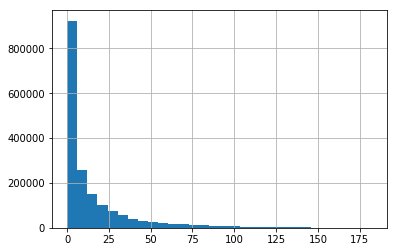

In [17]:
# TimeDiff (구매한 세션 간의 간격 - 일(day) 단위)
session['TimeDiff'].hist(bins=30)

In [18]:
session['TimeDiff'].describe()

count    1.790170e+06
mean     1.563015e+01
std      2.360767e+01
min      0.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.900000e+01
max      1.820000e+02
Name: TimeDiff, dtype: float64

In [19]:
# BUY_TOT_AM (한 고객의 한 세션에서의 총 구매 금액)
session['BUY_TOT_AM'].describe()

count    2.712907e+06
mean     1.001855e+05
std      2.372877e+05
min      1.000000e+01
25%      2.840000e+04
50%      5.280000e+04
75%      1.036000e+05
max      6.220000e+07
Name: BUY_TOT_AM, dtype: float64

(array([6.7654e+05, 3.5100e+02, 5.1000e+01, 1.1000e+01, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  103610.,  6313249., 12522888., 18732527., 24942166., 31151805.,
        37361444., 43571083., 49780722., 55990361., 62200000.]),
 <a list of 10 Patch objects>)

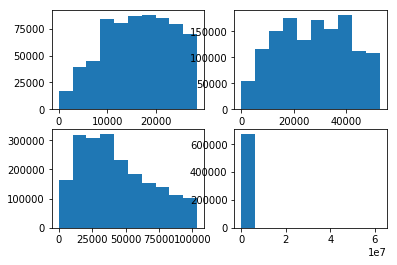

In [20]:
# 구매금액(BUY_TOT_AM)의 분포

plt.subplot(221) 
plt.hist(session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 25)]['BUY_TOT_AM'])

plt.subplot(222)
plt.hist(session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 50)]['BUY_TOT_AM'])

plt.subplot(223)
plt.hist(session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 75)]['BUY_TOT_AM'])

plt.subplot(224)
plt.hist(session[session['BUY_TOT_AM']>np.percentile(session['BUY_TOT_AM'], 75)]['BUY_TOT_AM'])

(array([3.01938e+05, 5.13830e+04, 2.14900e+04, 1.24470e+04, 7.21600e+03,
        4.64700e+03, 2.67600e+03, 1.56400e+03, 8.02000e+02, 2.39000e+02]),
 array([  0. ,  18.2,  36.4,  54.6,  72.8,  91. , 109.2, 127.4, 145.6,
        163.8, 182. ]),
 <a list of 10 Patch objects>)

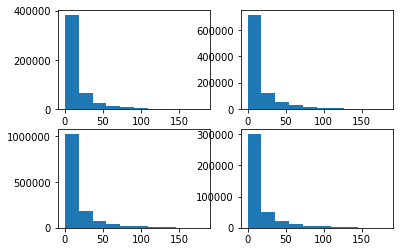

In [21]:
## BUY_TOT_AM(구매금액)의 구간 별로 나눴을 때, TimeDIff(구매 시간 간격)의 분포

plt.subplot(221) 
plt.hist(session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 25)]['TimeDiff'].dropna())

plt.subplot(222)
plt.hist(session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 50)]['TimeDiff'].dropna())

plt.subplot(223)
plt.hist(session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 75)]['TimeDiff'].dropna())

plt.subplot(224)
plt.hist(session[session['BUY_TOT_AM']>np.percentile(session['BUY_TOT_AM'], 75)]['TimeDiff'].dropna())

{'whiskers': [<matplotlib.lines.Line2D at 0x26703ac2b70>,
 'caps': [<matplotlib.lines.Line2D at 0x26703b094a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x26703ac2ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x26703b09cc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x26703e91588>],
 'means': []}

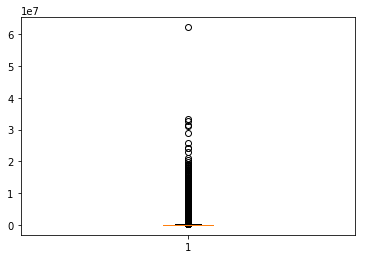

In [17]:
plt.boxplot(session['BUY_TOT_AM'])  # 이상치 존재

In [114]:
## 이상치 기준은 BUY_TOT_AM(한 세션의 총 구매금액)의 상위 3%로 설정
# 이유: 리서치 결과, 이커머스의 1회 평균 구매금액은 7.2만원(PC), 6.0만원(모바일)인데, 상위 3%를 제외했을 때 BUY_TOT_AM의 평균치가 7.2만원에 가장 가까워짐
# 이유2: 상위 3%를 제외했을 때, 최댓값은 397,940원. 이는 상식 선에서 충분히 용인 가능한 금액이다.
session2 = session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 97)]

{'whiskers': [<matplotlib.lines.Line2D at 0x11858a66a58>,
 'caps': [<matplotlib.lines.Line2D at 0x11858abdfd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11858abd160>],
 'medians': [<matplotlib.lines.Line2D at 0x118598e68d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x118598e6d30>],
 'means': []}

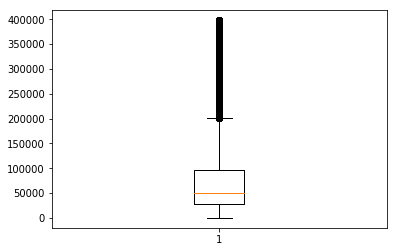

In [115]:
plt.boxplot(session2['BUY_TOT_AM'])

In [116]:
max(session2['BUY_TOT_AM'])

397940

In [117]:
np.mean(session2['BUY_TOT_AM'])

74515.71494303468

(array([5.024742e+06, 1.300000e+02, 2.100000e+01, 5.000000e+00,
        3.000000e+00, 2.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.0000000e+01, 3.9000090e+06, 7.8000080e+06, 1.1700007e+07,
        1.5600006e+07, 1.9500005e+07, 2.3400004e+07, 2.7300003e+07,
        3.1200002e+07, 3.5100001e+07, 3.9000000e+07]),
 <a list of 10 Patch objects>)

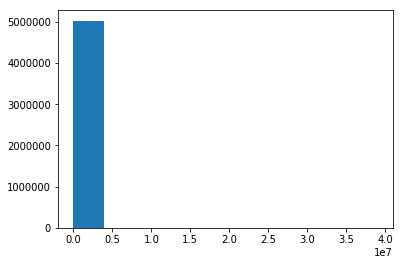

In [19]:
## BUY_TOT_AM(구매금액)의 구간 별로 나눴을 때, TimeDIff(구매 시간 간격)의 분포

plt.subplot(221) 
plt.hist(product[product['TOT_AM']<np.percentile(session['TOT_AM'], 25)]['TOT_AM']

plt.subplot(222)
plt.hist(product[product['TOT_AM']<np.percentile(session['BUY_TOT_AM'], 50)]['TOT_AM']

plt.subplot(223)
plt.hist(session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 75)]['TOT_AM']

plt.subplot(224)
plt.hist(session[session['BUY_TOT_AM']>np.percentile(session['BUY_TOT_AM'], 75)]['TOT_AM']

In [99]:
test=session2.groupby('TimeDiff',as_index=False).size().reset_index(name = 'count')

In [101]:
## 재구매 간격이 0일인 경우는 제외
test = test[test['TimeDiff'] != 0.0 ]

In [103]:
def findSplitPoint(test, n) : 
   
    left = list()
    right = list()
    splitpoint = list()
    
    leftSum = 0 
    # traverse array element 
    for i in range(0, n) : 
       
        # add current element to left Sum 
        leftSum += test.iloc[i,1]  
        left.append(leftSum)
        splitpoint.append(i+1)
        # find sum of rest array elements (rightSum) 
        rightSum = 0 
        for j in range(i+1, n) : 
            rightSum += test.iloc[j,1]
        
        right.append(rightSum)
    # split poindex 
    return left,right,splitpoint

In [104]:
left,right,splitpoint = findSplitPoint(test,182)

In [105]:
Decider =pd.DataFrame(np.vstack([splitpoint,left, right]).T,
              columns=['splitpoint','leftsum', 'rightsum'])

In [106]:
## "6일"을 기준으로 나눴을 때, label 1과 0에 배정되는 데이터의 갯수가 가장 비슷함
## 이는 리서치 결과와도 일맥상통함. 리서치 결과, 온라인쇼핑몰 사용자들은 평균적으로 "5.08일"에 한번씩 쇼핑함.
Decider

,splitpoint,leftsum,rightsum
0,1,216081,1318338
1,2,357064,1177355
2,3,464934,1069485
3,4,551712,982707
4,5,623597,910822
5,6,688209,846210
6,7,748343,786076
7,8,796298,738121
8,9,837009,697410
9,10,873974,660445


In [132]:
# 이상치 데이터
session2 = session[session['BUY_TOT_AM']<np.percentile(session['BUY_TOT_AM'], 97)]
outlier_id = session[session['BUY_TOT_AM']>=np.percentile(session['BUY_TOT_AM'], 97)][['CLNT_ID', 'SESS_ID']]
CLNT_list = list(outlier_id['CLNT_ID'])
SESS_list = list(outlier_id['SESS_ID'])